In [1]:
#Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
#read in dataframe from source
source = 'Data'
pkmndf = pd.read_csv(os.path.join(source, 'pokemon.csv'))
bttlsdf = pd.read_csv(os.path.join(source, 'combats.csv'))

In [3]:
stats = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
stats_dict = {}
#Using a loop to add all stats to a dictionary
for s in stats:
    temp_list = []
    for i in bttlsdf['First_pokemon']:
        stat = pkmndf.at[i-1, s]
        temp_list.append(stat)
        stats_dict[f'{s}']=temp_list

In [4]:
stats_dict2 = {}
#Copying for second pokemon
for s in stats:
    temp_list = []
    for i in bttlsdf['Second_pokemon']:
        stat = pkmndf.at[i-1, s]
        temp_list.append(stat)
        stats_dict2[f'{s}']=temp_list

In [5]:
#Create all 12 new features with one simple for loop
for k in stats_dict.keys():
    bttlsdf[f'P1_{k}'] = stats_dict[k]
    bttlsdf[f'P2_{k}'] = stats_dict2[k]

In [6]:
bttlsdf['P1_HighSpeed'] = bttlsdf['P1_Speed']>bttlsdf['P2_Speed']

In [7]:
from IPython.display import display
pd.options.display.max_columns = None

In [8]:
#Have a quick look to begin exploration
bttlsdf.head(10)

,First_pokemon,Second_pokemon,Winner,P1_HP,P2_HP,P1_Attack,P2_Attack,P1_Defense,P2_Defense,P1_Sp. Atk,P2_Sp. Atk,P1_Sp. Def,P2_Sp. Def,P1_Speed,P2_Speed,P1_HighSpeed
0,266,298,298,50,70,64,70,50,40,45,60,50,40,41,60,False
1,702,701,701,91,91,90,129,72,90,90,72,129,90,108,108,False
2,191,668,668,55,75,40,75,85,75,80,125,105,95,40,40,False
3,237,683,683,40,77,40,120,40,90,70,60,40,90,20,48,False
4,151,231,151,70,20,60,10,125,230,115,10,70,230,55,5,True
5,657,752,657,50,60,47,50,50,150,57,50,50,150,65,60,True
6,192,134,134,40,65,50,50,45,35,70,115,45,95,70,95,False
7,73,545,545,70,150,80,100,50,120,35,100,35,120,35,90,False
8,220,763,763,50,50,65,53,90,62,35,58,35,63,15,44,False
9,302,31,31,40,35,30,55,30,40,55,50,30,50,85,90,False


In [9]:
bttlsdf['P1_Winner'] = bttlsdf['Winner'] == bttlsdf['First_pokemon']

In [10]:
#Dropping irellevant columns
bttlsdf.drop(columns = ['First_pokemon', 'Second_pokemon'], inplace = True)

In [11]:
#Grab some packages we'll need for data prep and model fitting
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [12]:
train, val = train_test_split(bttlsdf)
train.head()

,Winner,P1_HP,P2_HP,P1_Attack,P2_Attack,P1_Defense,P2_Defense,P1_Sp. Atk,P2_Sp. Atk,P1_Sp. Def,P2_Sp. Def,P1_Speed,P2_Speed,P1_HighSpeed,P1_Winner
43407,519,75,125,95,58,67,58,125,76,95,76,83,67,True,True
22957,137,65,65,125,80,100,65,55,35,70,65,85,60,True,True
6138,62,50,40,85,80,40,35,85,35,40,45,35,70,False,False
46895,23,83,100,80,100,75,100,70,100,70,100,101,100,True,True
13258,30,50,60,50,85,40,69,30,65,30,79,50,80,False,False


In [15]:
train, test = train_test_split(train)
train.head()

,Winner,P1_HP,P2_HP,P1_Attack,P2_Attack,P1_Defense,P2_Defense,P1_Sp. Atk,P2_Sp. Atk,P1_Sp. Def,P2_Sp. Def,P1_Speed,P2_Speed,P1_HighSpeed,P1_Winner
39826,532,45,50,53,50,70,77,40,95,60,77,42,91,False,False
9202,567,60,65,55,80,90,65,145,35,90,65,80,60,True,False
17882,409,50,95,64,135,50,80,45,110,50,80,41,100,False,False
35313,554,65,100,60,100,110,100,130,100,95,100,65,100,False,False
8241,733,38,45,35,22,40,60,27,27,25,30,35,29,True,True


In [16]:
#Establish x features and y target
target = 'P1_Winner'
drops = ['Winner', 'P1_Winner', 'P1_HighSpeed']
X_train = train.drop(drops, axis = 1)
X_val = val.drop(drops, axis = 1)
X_test = test.drop(drops, axis = 1)

y_train = train[target]
y_val = val[target]
y_test = test[target]

In [17]:
#Create, fit and predict with no hyperparameters for a baseline
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

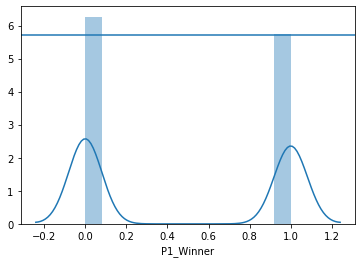

In [18]:
#Have a look at distribution of our y_true before predicting
import matplotlib.pyplot as plt
import seaborn as sns
#They aren't perfectly even, but the difference isn't large
sns.distplot(y_val.astype(int))
#Added this line to make the difference easier to see
plt.axhline(5.7, 0, 1)

In [19]:
#Grab accuracy score for our metric
from sklearn.metrics import accuracy_score

In [20]:
#Convert predictions to int for accuracy_score
y_pred_int = y_pred.astype(int)

In [21]:
#Making sure it worked
y_pred_int

array([0, 0, 1, ..., 0, 0, 0])

In [23]:
#Getting our score
accuracy_score(y_val, y_pred)

0.92432

In [24]:
from sklearn.metrics import classification_report
#Import then use classification report to check more metrics
#print call is necessary to make it readable
print(classification_report(y_val, y_pred_int))

              precision    recall  f1-score   support

       False       0.93      0.93      0.93      6526
        True       0.92      0.92      0.92      5974

    accuracy                           0.92     12500
   macro avg       0.92      0.92      0.92     12500
weighted avg       0.92      0.92      0.92     12500



In [25]:
#Import confusion_matrix, then make a function to quickly plot it
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true,y_pred, normalize=True):
    cm = confusion_matrix(y_true, y_pred)
    columns = [f'Predicted {c}'for c in y_true.unique()]
    index_names = [f'Actual {c}'for c in y_true.unique()]
    if normalize:
        cm = cm/cm.sum(axis = 1).reshape(y_true.nunique(),1)
    df = pd.DataFrame(cm, columns = columns, index = index_names)
    sns.heatmap(df, cmap = 'viridis', annot = True, fmt='.2f')

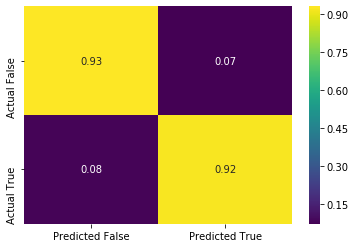

In [26]:
#Plot the confusion matrix for our predictions
plot_confusion_matrix(y_val, y_pred)

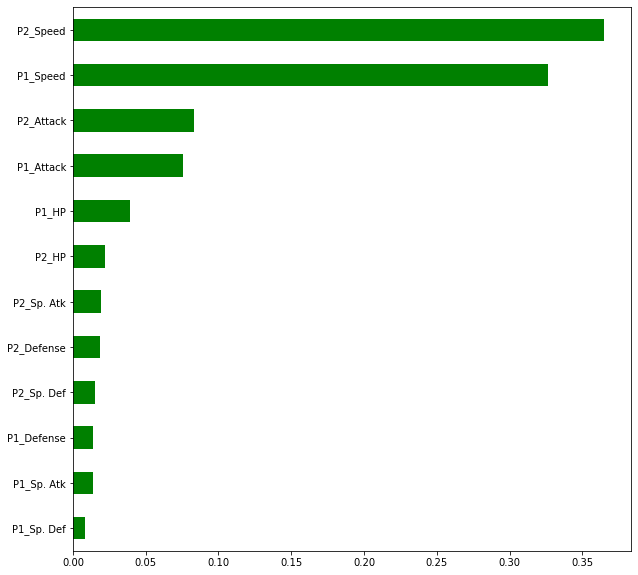

In [27]:
plt.figure(figsize = (10,10))

importances = pd.Series(model.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color = 'green')



In [28]:
drops2 = ['Winner', 'P1_Winner']
X_train2 = train.drop(drops2, axis = 1)
X_val2 = val.drop(drops2, axis = 1)
X_test2 = test.drop(drops2, axis = 1)

y_train2 = train[target]
y_val2 = val[target]
y_test2 = test[target]

In [29]:
X_train2.head()

,P1_HP,P2_HP,P1_Attack,P2_Attack,P1_Defense,P2_Defense,P1_Sp. Atk,P2_Sp. Atk,P1_Sp. Def,P2_Sp. Def,P1_Speed,P2_Speed,P1_HighSpeed
39826,45,50,53,50,70,77,40,95,60,77,42,91,False
9202,60,65,55,80,90,65,145,35,90,65,80,60,True
17882,50,95,64,135,50,80,45,110,50,80,41,100,False
35313,65,100,60,100,110,100,130,100,95,100,65,100,False
8241,38,45,35,22,40,60,27,27,25,30,35,29,True


In [31]:
model2 = XGBClassifier(n_estimators = 1000, max_depth = 50)
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_val2)

In [32]:
y_pred2

array([False, False,  True, ..., False, False, False])

In [33]:
accuracy_score(y_val2, y_pred2)

0.95384

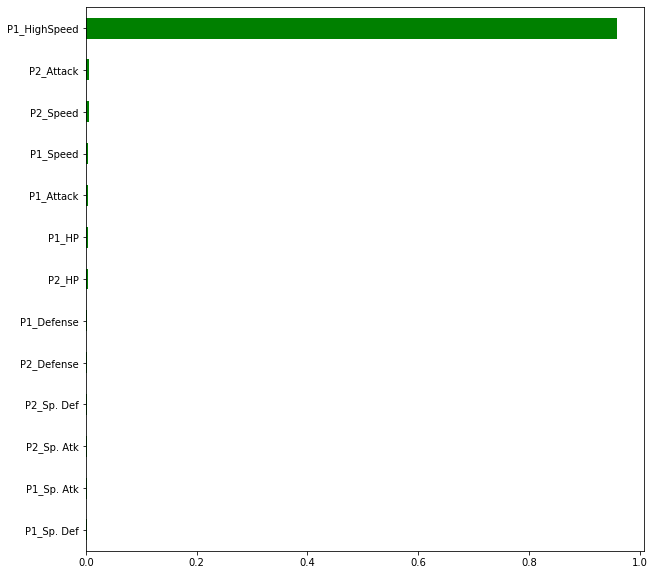

In [34]:
plt.figure(figsize = (10,10))
importances2 = pd.Series(model2.feature_importances_, X_train2.columns)
importances2.sort_values().plot.barh(color = 'green')

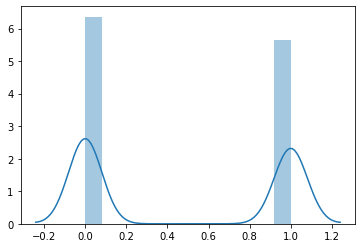

In [48]:
sns.distplot(y_pred_int2)

In [24]:
stats_dict = {}
#Using a loop to add all stats to a dictionary
for i in input():
    pkmn = i
    for s in stats:
        temp_list = []
        #Insuring the input is in int format
        if int(pkmn):
            stat = pkmndf.at[int(pkmn)-1, s]
            temp_list.append(stat)
            stats_dict[f'{s}']=temp_list
            print(stats_dict)

002
{'HP': [60]}
{'HP': [60], 'Attack': [62]}
{'HP': [60], 'Attack': [62], 'Defense': [63]}
{'HP': [60], 'Attack': [62], 'Defense': [63], 'Sp. Atk': [80]}
{'HP': [60], 'Attack': [62], 'Defense': [63], 'Sp. Atk': [80], 'Sp. Def': [80]}
{'HP': [60], 'Attack': [62], 'Defense': [63], 'Sp. Atk': [80], 'Sp. Def': [80], 'Speed': [60]}


In [66]:
X_train.head()

,P1_HP,P2_HP,P1_Attack,P2_Attack,P1_Defense,P2_Defense,P1_Sp. Atk,P2_Sp. Atk,P1_Sp. Def,P2_Sp. Def,P1_Speed,P2_Speed
39736,75,65,75,65,55,60,105,130,85,95,30,110
44067,70,65,115,85,60,70,115,75,60,70,55,40
10436,60,100,45,150,70,140,75,100,85,90,55,90
24858,110,65,130,90,80,40,70,45,60,80,80,75
17590,80,40,95,45,82,40,60,35,82,35,75,56


In [67]:
X_train2.head()

,P1_HP,P2_HP,P1_Attack,P2_Attack,P1_Defense,P2_Defense,P1_Sp. Atk,P2_Sp. Atk,P1_Sp. Def,P2_Sp. Def,P1_Speed,P2_Speed,P1_HighSpeed
43895,65,60,90,60,40,60,45,60,80,60,75,60,True
7272,55,60,55,150,50,50,45,150,65,50,55,60,False
34696,75,60,90,52,90,168,140,47,90,138,115,30,True
39106,58,45,109,85,112,50,48,55,48,50,109,65,True
29457,65,74,40,94,70,131,80,54,140,116,70,20,True
